In [11]:
import warnings
# Suppress warnings
warnings.filterwarnings('ignore')

In [12]:
import pandas as pd
import numpy as np
import requests
import re
import time
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import ast  # Import ast for safe evaluation of strings
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.optimizers import Adam

In [13]:
# For plotting
%matplotlib inline

# Set the style for seaborn
sns.set(style='whitegrid')

# Step 1: Data Preprocessing

In [14]:
# Load the dataset
books_df = pd.read_csv('books_recommendation_dataset.csv')

In [15]:
# Display the first few rows
books_df.head()

Title              Authors  \
0              The Classical Music Book               ['DK']   
1                                 Khyal   ['Bonnie C. Wade']   
2  The Vintage Guide to Classical Music     ['Jan Swafford']   
3            Who Needs Classical Music?   ['Julian Johnson']   
4                       Classical Music  ['Alexander Waugh']   

                      Publisher Published Date  \
0        Dorling Kindersley Ltd     2018-12-04   
1                   CUP Archive           1984   
2     National Geographic Books     1992-12-15   
3                           NaN           2002   
4  MacMillan Publishing Company           1995   

                                         Description Categories  Page Count  \
0  Learn about the world's greatest classical com...  ['Music']       708.0   
1  Bonnie C. Wade studies khyal and the cultural ...  ['Music']       344.0   
2  The most readable and comprehensive guide to e...  ['Music']         0.0   
3  During the last few decades, most cultural cri...  ['Music']       158.0   
4  Here is an innovative and thoroughly enjoyable...  ['Music']       152.0   

   Average Rating  Ratings Count Language     ISBN-10       ISBN-13  \
0             NaN            NaN       en  0241373212  9.780241e+12   
1             5.0            1.0       en  0521256593  9.780521e+12   
2             NaN            NaN       en  0679728058  9.780680e+12   
3             NaN            NaN       en  0195146816  9.780195e+12   
4             NaN            NaN       en         NaN           NaN   

                                        Preview Link  \
0  http://books.google.co.in/books?id=qV5gDwAAQBA...   
1  http://books.google.co.in/books?id=MiE9AAAAIAA...   
2  http://books.google.co.in/books?id=WquOEAAAQBA...   
3  http://books.google.co.in/books?id=oPx0RyZoOuo...   
4  http://books.google.co.in/books?id=DdE7AQAAIAA...   

                                           Thumbnail Maturity Rating  
0  http://books.google.com/books/content?id=qV5gD...      NOT_MATURE  
1  http://books.google.com/books/content?id=MiE9A...      NOT_MATURE  
2  http://books.google.com/books/content?id=WquOE...      NOT_MATURE  
3  http://books.google.com/books/content?id=oPx0R...      NOT_MATURE  
4  http://books.google.com/books/content?id=DdE7A...      NOT_MATURE

In [16]:
# Check for missing values
missing_values = books_df.isnull().sum()
print(missing_values)

Title                 1
Authors             163
Publisher          1368
Published Date       76
Description         745
Categories          908
Page Count          190
Average Rating     5621
Ratings Count      5621
Language              0
ISBN-10             960
ISBN-13             836
Preview Link          0
Thumbnail           389
Maturity Rating       0
dtype: int64


In [17]:
# Option 1: Drop rows with missing values
books_df_cleaned = books_df.dropna()

In [18]:
# Option 2: Fill missing values (for example, filling missing 'Description' with an empty string)
books_df_filled = books_df.fillna({'Description': '', 'Average Rating': 0, 'Ratings Count': 0})

In [19]:
# Display the cleaned dataset
books_df_cleaned.head()

Title  \
1                                          Khyal   
105                             Classical Greece   
115                      The Classical Tradition   
132                          CLASSICAL MECHANICS   
150  Lectures on Classical Differential Geometry   

                                               Authors  \
1                                   ['Bonnie C. Wade']   
105                                     ['Ian Morris']   
115  ['Anthony Grafton', 'Glenn W. Most', 'Salvator...   
132                   ['R. N. TIWARI', 'B. S. THAKUR']   
150                                 ['Dirk J. Struik']   

                      Publisher Published Date  \
1                   CUP Archive           1984   
105  Cambridge University Press     1994-06-23   
115    Harvard University Press     2010-10-25   
132      PHI Learning Pvt. Ltd.     2007-02-05   
150         Courier Corporation     2012-04-26   

                                           Description       Categories  \
1    Bonnie C. Wade studies khyal and the cultural ...        ['Music']   
105  A reassessment of the archaeology of classical...      ['History']   
115  The legacy of ancient Greece and Rome has been...      ['History']   
132  Intended as a text for postgraduate students o...      ['Science']   
150  Elementary, yet authoritative and scholarly, t...  ['Mathematics']   

     Page Count  Average Rating  Ratings Count Language     ISBN-10  \
1         344.0             5.0            1.0       en  0521256593   
105       264.0             3.0            1.0       en  0521456789   
115      1188.0             5.0            1.0       en  0674035720   
132       192.0             4.0            1.0       en  8120331265   
150       254.0             1.0            1.0       en  0486138186   

          ISBN-13                                       Preview Link  \
1    9.780521e+12  http://books.google.co.in/books?id=MiE9AAAAIAA...   
105  9.780521e+12  http://books.google.co.in/books?id=fnJvha8jzzQ...   
115  9.780674e+12  http://books.google.co.in/books?id=LbqF8z2bq3s...   
132  9.788120e+12  http://books.google.co.in/books?id=r8wa9_pe8g4...   
150  9.780486e+12  http://books.google.co.in/books?id=JVC8AQAAQBA...   

                                             Thumbnail Maturity Rating  
1    http://books.google.com/books/content?id=MiE9A...      NOT_MATURE  
105  http://books.google.com/books/content?id=fnJvh...      NOT_MATURE  
115  http://books.google.com/books/content?id=LbqF8...      NOT_MATURE  
132  http://books.google.com/books/content?id=r8wa9...      NOT_MATURE  
150  http://books.google.com/books/content?id=JVC8A...      NOT_MATURE

In [20]:
# Remove duplicate entries based on the 'Title' or 'ISBN-13'
books_df_cleaned = books_df_cleaned.drop_duplicates(subset=['Title', 'ISBN-13'])

In [21]:
# Display the cleaned dataset
books_df_cleaned.head()

Title  \
1                                          Khyal   
105                             Classical Greece   
115                      The Classical Tradition   
132                          CLASSICAL MECHANICS   
150  Lectures on Classical Differential Geometry   

                                               Authors  \
1                                   ['Bonnie C. Wade']   
105                                     ['Ian Morris']   
115  ['Anthony Grafton', 'Glenn W. Most', 'Salvator...   
132                   ['R. N. TIWARI', 'B. S. THAKUR']   
150                                 ['Dirk J. Struik']   

                      Publisher Published Date  \
1                   CUP Archive           1984   
105  Cambridge University Press     1994-06-23   
115    Harvard University Press     2010-10-25   
132      PHI Learning Pvt. Ltd.     2007-02-05   
150         Courier Corporation     2012-04-26   

                                           Description       Categories  \
1    Bonnie C. Wade studies khyal and the cultural ...        ['Music']   
105  A reassessment of the archaeology of classical...      ['History']   
115  The legacy of ancient Greece and Rome has been...      ['History']   
132  Intended as a text for postgraduate students o...      ['Science']   
150  Elementary, yet authoritative and scholarly, t...  ['Mathematics']   

     Page Count  Average Rating  Ratings Count Language     ISBN-10  \
1         344.0             5.0            1.0       en  0521256593   
105       264.0             3.0            1.0       en  0521456789   
115      1188.0             5.0            1.0       en  0674035720   
132       192.0             4.0            1.0       en  8120331265   
150       254.0             1.0            1.0       en  0486138186   

          ISBN-13                                       Preview Link  \
1    9.780521e+12  http://books.google.co.in/books?id=MiE9AAAAIAA...   
105  9.780521e+12  http://books.google.co.in/books?id=fnJvha8jzzQ...   
115  9.780674e+12  http://books.google.co.in/books?id=LbqF8z2bq3s...   
132  9.788120e+12  http://books.google.co.in/books?id=r8wa9_pe8g4...   
150  9.780486e+12  http://books.google.co.in/books?id=JVC8AQAAQBA...   

                                             Thumbnail Maturity Rating  
1    http://books.google.com/books/content?id=MiE9A...      NOT_MATURE  
105  http://books.google.com/books/content?id=fnJvh...      NOT_MATURE  
115  http://books.google.com/books/content?id=LbqF8...      NOT_MATURE  
132  http://books.google.com/books/content?id=r8wa9...      NOT_MATURE  
150  http://books.google.com/books/content?id=JVC8A...      NOT_MATURE

In [22]:
# Function to clean text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Remove extra whitespace
    return text

# Apply text cleaning to 'Title' and 'Description'
books_df_cleaned['Title'] = books_df_cleaned['Title'].apply(clean_text)
books_df_cleaned['Description'] = books_df_cleaned['Description'].apply(clean_text)

# Display the cleaned dataset
books_df_cleaned[['Title', 'Description']].head()


Title  \
1                                          khyal   
105                             classical greece   
115                      the classical tradition   
132                          classical mechanics   
150  lectures on classical differential geometry   

                                           Description  
1    bonnie c wade studies khyal and the cultural h...  
105  a reassessment of the archaeology of classical...  
115  the legacy of ancient greece and rome has been...  
132  intended as a text for postgraduate students o...  
150  elementary yet authoritative and scholarly thi...

# Step 2: Exploratory Data Analysis (EDA)

In [23]:
# Overview of the dataset
print(books_df_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 464 entries, 1 to 6230
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Title            464 non-null    object 
 1   Authors          464 non-null    object 
 2   Publisher        464 non-null    object 
 3   Published Date   464 non-null    object 
 4   Description      464 non-null    object 
 5   Categories       464 non-null    object 
 6   Page Count       464 non-null    float64
 7   Average Rating   464 non-null    float64
 8   Ratings Count    464 non-null    float64
 9   Language         464 non-null    object 
 10  ISBN-10          464 non-null    object 
 11  ISBN-13          464 non-null    float64
 12  Preview Link     464 non-null    object 
 13  Thumbnail        464 non-null    object 
 14  Maturity Rating  464 non-null    object 
dtypes: float64(4), object(11)
memory usage: 58.0+ KB
None


In [24]:
# Basic statistics
print(books_df_cleaned.describe())

        Page Count  Average Rating  Ratings Count       ISBN-13
count   464.000000      464.000000     464.000000  4.640000e+02
mean    365.803879        4.229526       4.762931  9.781820e+12
std     272.424841        1.022221      13.865905  2.516910e+09
min       0.000000        1.000000       1.000000  9.780007e+12
25%     221.250000        4.000000       1.000000  9.780440e+12
50%     314.000000        4.500000       1.000000  9.781250e+12
75%     420.750000        5.000000       3.000000  9.781589e+12
max    2838.000000        5.000000     182.000000  9.789391e+12


In [25]:
# Check the distribution of numeric features
print(books_df_cleaned[['Page Count', 'Average Rating', 'Ratings Count']].describe())

        Page Count  Average Rating  Ratings Count
count   464.000000      464.000000     464.000000
mean    365.803879        4.229526       4.762931
std     272.424841        1.022221      13.865905
min       0.000000        1.000000       1.000000
25%     221.250000        4.000000       1.000000
50%     314.000000        4.500000       1.000000
75%     420.750000        5.000000       3.000000
max    2838.000000        5.000000     182.000000


In [26]:
# Count the number of books per genre
genres_list = books_df_cleaned['Categories'].dropna().apply(lambda x: x[0] if isinstance(x, list) else x).value_counts()

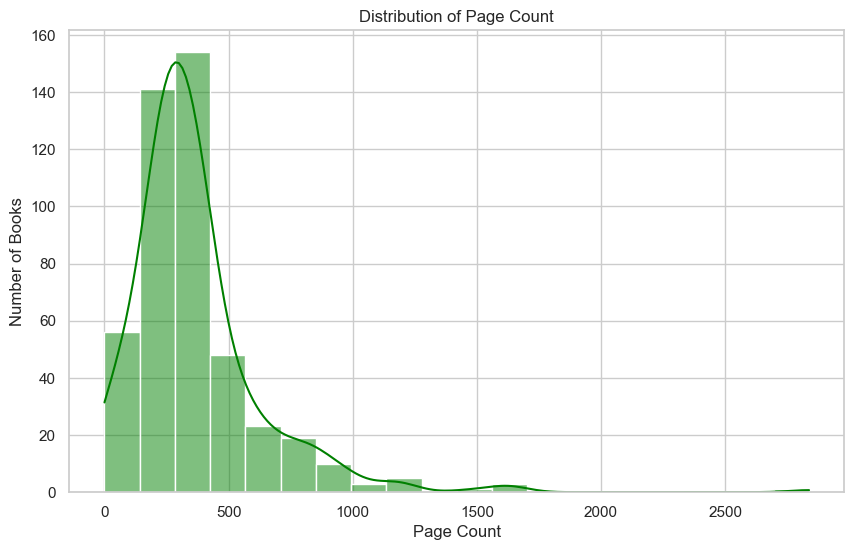

In [27]:
# Plot the distribution of 'Page Count' to understand how book lengths vary.
plt.figure(figsize=(10, 6))
sns.histplot(books_df_cleaned['Page Count'].dropna(), bins=20, kde=True, color='green')
plt.title('Distribution of Page Count')
plt.xlabel('Page Count')
plt.ylabel('Number of Books')
plt.show()


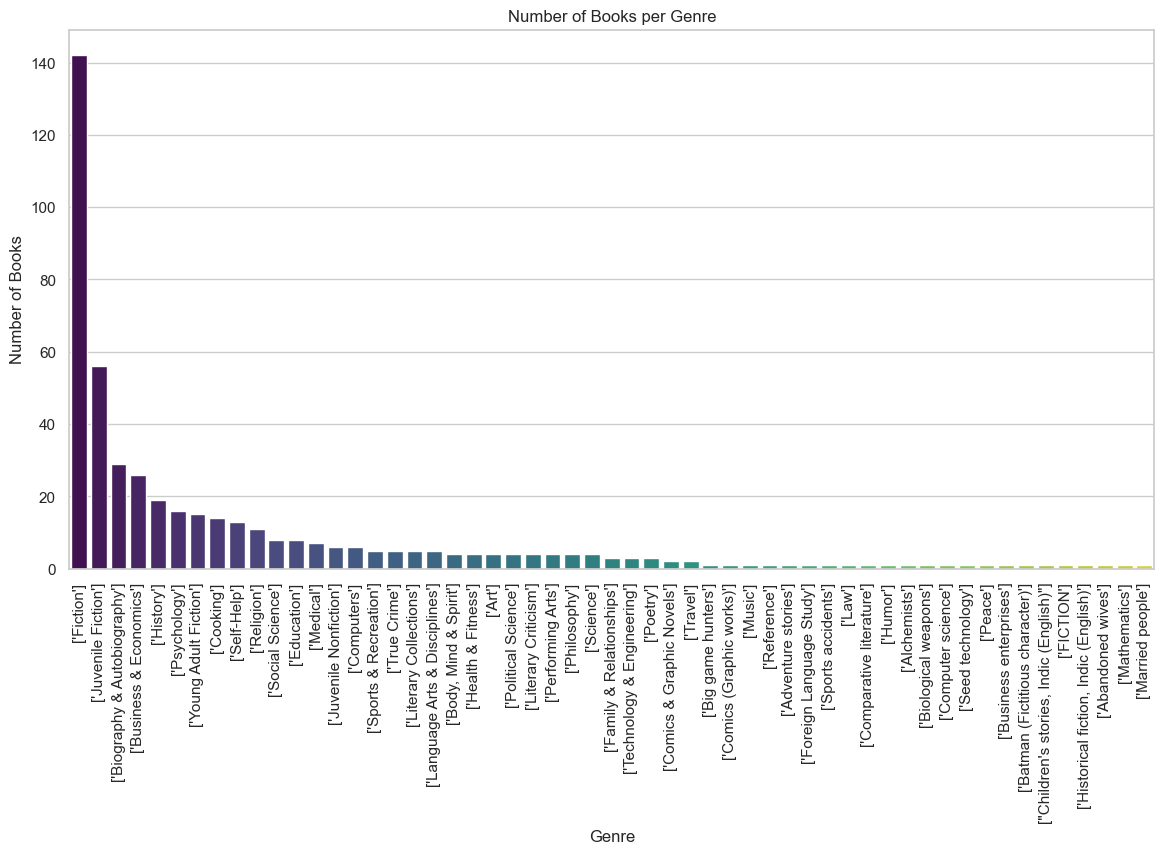

In [28]:
# Count the number of books in each genre/category and plot it.
plt.figure(figsize=(14, 7))
sns.barplot(x=genres_list.index, y=genres_list.values, palette='viridis')
plt.xticks(rotation=90)
plt.title('Number of Books per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Books')
plt.show()


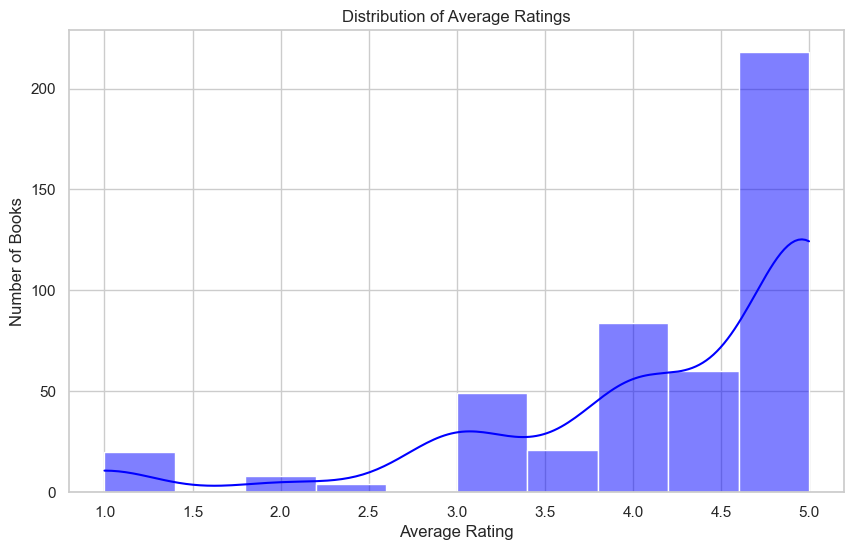

In [29]:
# Plot the distribution of 'Average Rating' to analyze the rating spread across books.
plt.figure(figsize=(10, 6))
sns.histplot(books_df_cleaned['Average Rating'].dropna(), bins=10, kde=True, color='blue')
plt.title('Distribution of Average Ratings')
plt.xlabel('Average Rating')
plt.ylabel('Number of Books')
plt.show()



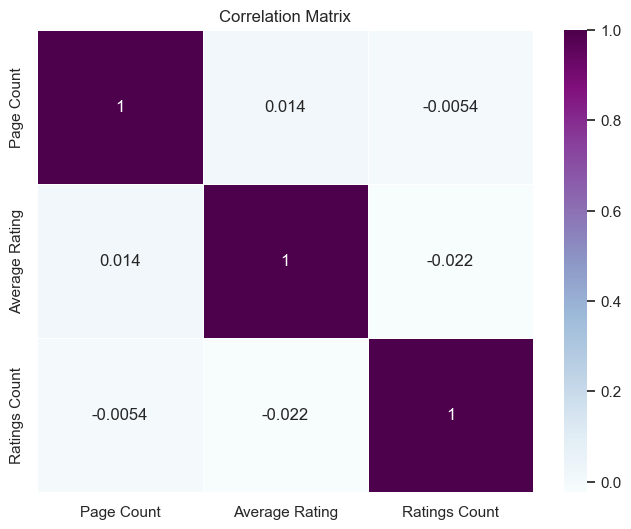

In [30]:
# Correlation matrix
correlation_matrix = books_df_cleaned[['Page Count', 'Average Rating', 'Ratings Count']].corr()

# Plot the correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='BuPu', linewidths=0.5)
plt.title('Correlation Matrix')
plt.show()


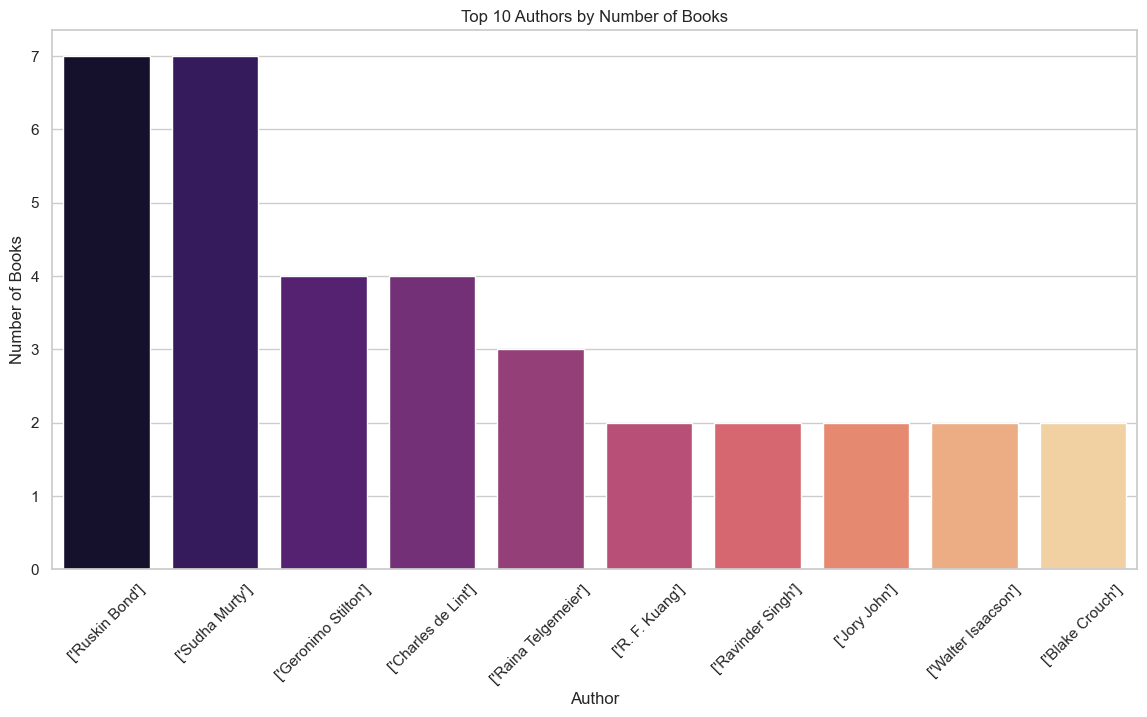

In [31]:
# Count the number of books per author
author_counts = books_df_cleaned['Authors'].dropna().apply(lambda x: x[0] if isinstance(x, list) else x).value_counts().head(10)

# Plot the top authors
plt.figure(figsize=(14, 7))
sns.barplot(x=author_counts.index, y=author_counts.values, palette='magma')
plt.title('Top 10 Authors by Number of Books')
plt.xlabel('Author')
plt.ylabel('Number of Books')
plt.xticks(rotation=45)
plt.show()

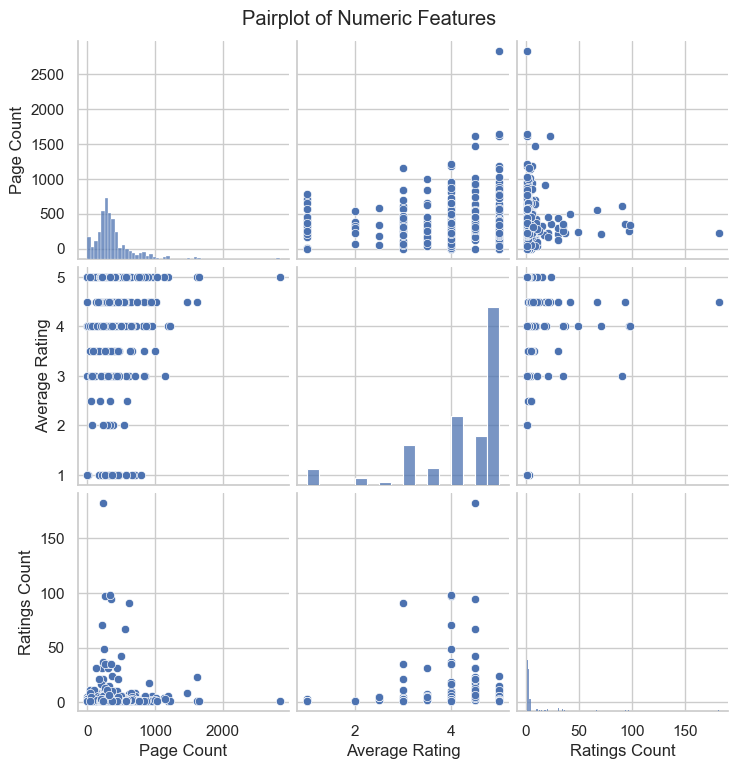

In [32]:
# Create pairplots to visualize relationships between the numeric features.
sns.pairplot(books_df_cleaned[['Page Count', 'Average Rating', 'Ratings Count']])
plt.suptitle('Pairplot of Numeric Features', y=1.02)
plt.show()

<Figure size 1000x600 with 0 Axes>

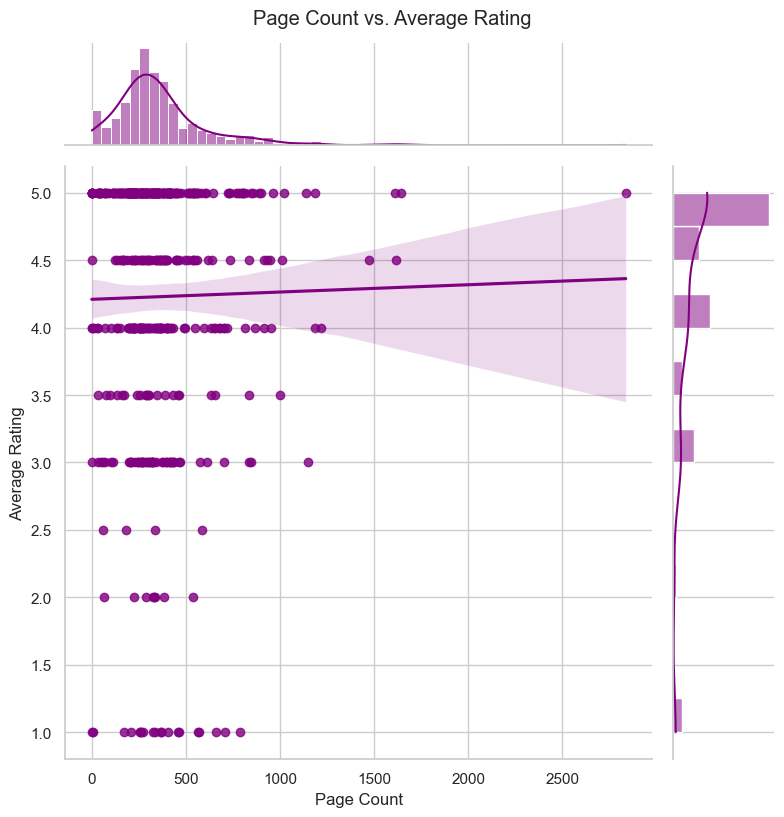

In [33]:
# Joint plot to explore the relationship between 'Page Count' and 'Average Rating'.
plt.figure(figsize=(10, 6))
sns.jointplot(x='Page Count', y='Average Rating', data=books_df_cleaned, kind='reg', height=8, color='purple')
plt.suptitle('Page Count vs. Average Rating', y=1.02)
plt.show()


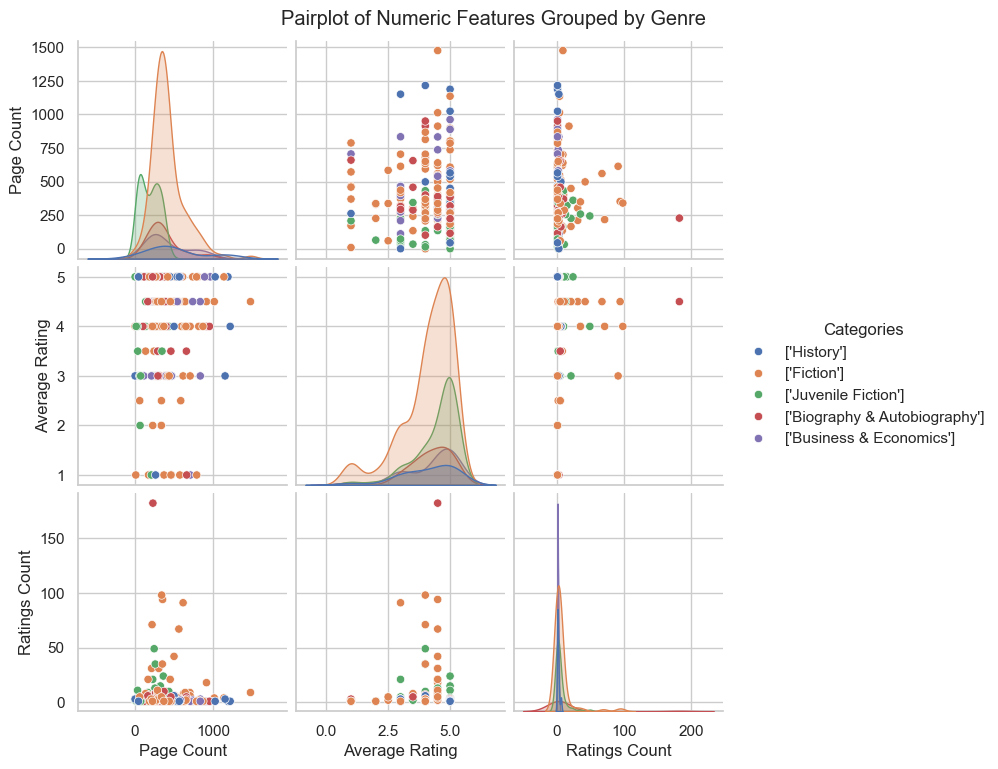

In [34]:
# Pairplot with hue based on 'Categories' to see relationships and distributions across multiple genres.
# To avoid overcrowding, you can filter to top N genres.
top_genres = genres_list.index[:5]  # Change to your preferred number of top genres
filtered_df = books_df_cleaned[books_df_cleaned['Categories'].isin(top_genres)]

sns.pairplot(filtered_df, hue='Categories', vars=['Page Count', 'Average Rating', 'Ratings Count'], height=2.5)
plt.suptitle('Pairplot of Numeric Features Grouped by Genre', y=1.02)
plt.show()


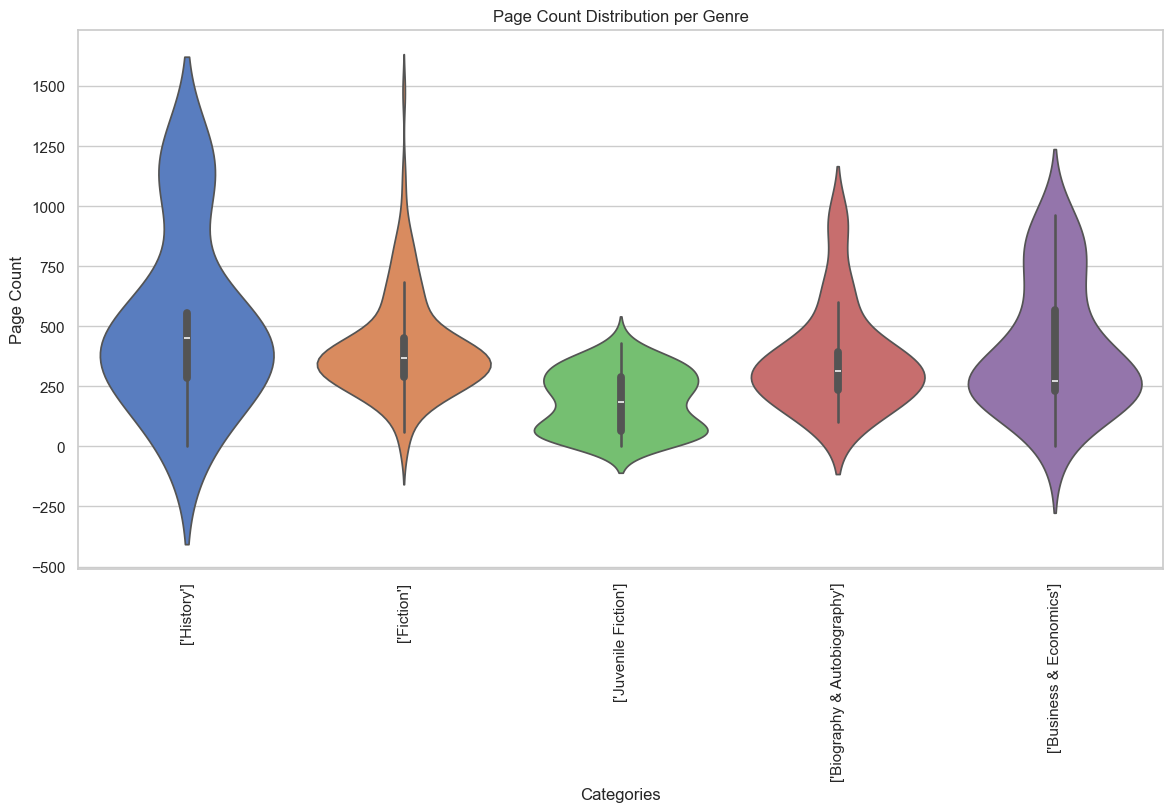

In [35]:
# Violin plot to visualize the distribution of 'Page Count' across different genres.
plt.figure(figsize=(14, 7))
sns.violinplot(x='Categories', y='Page Count', data=filtered_df, palette='muted')
plt.xticks(rotation=90)
plt.title('Page Count Distribution per Genre')
plt.show()


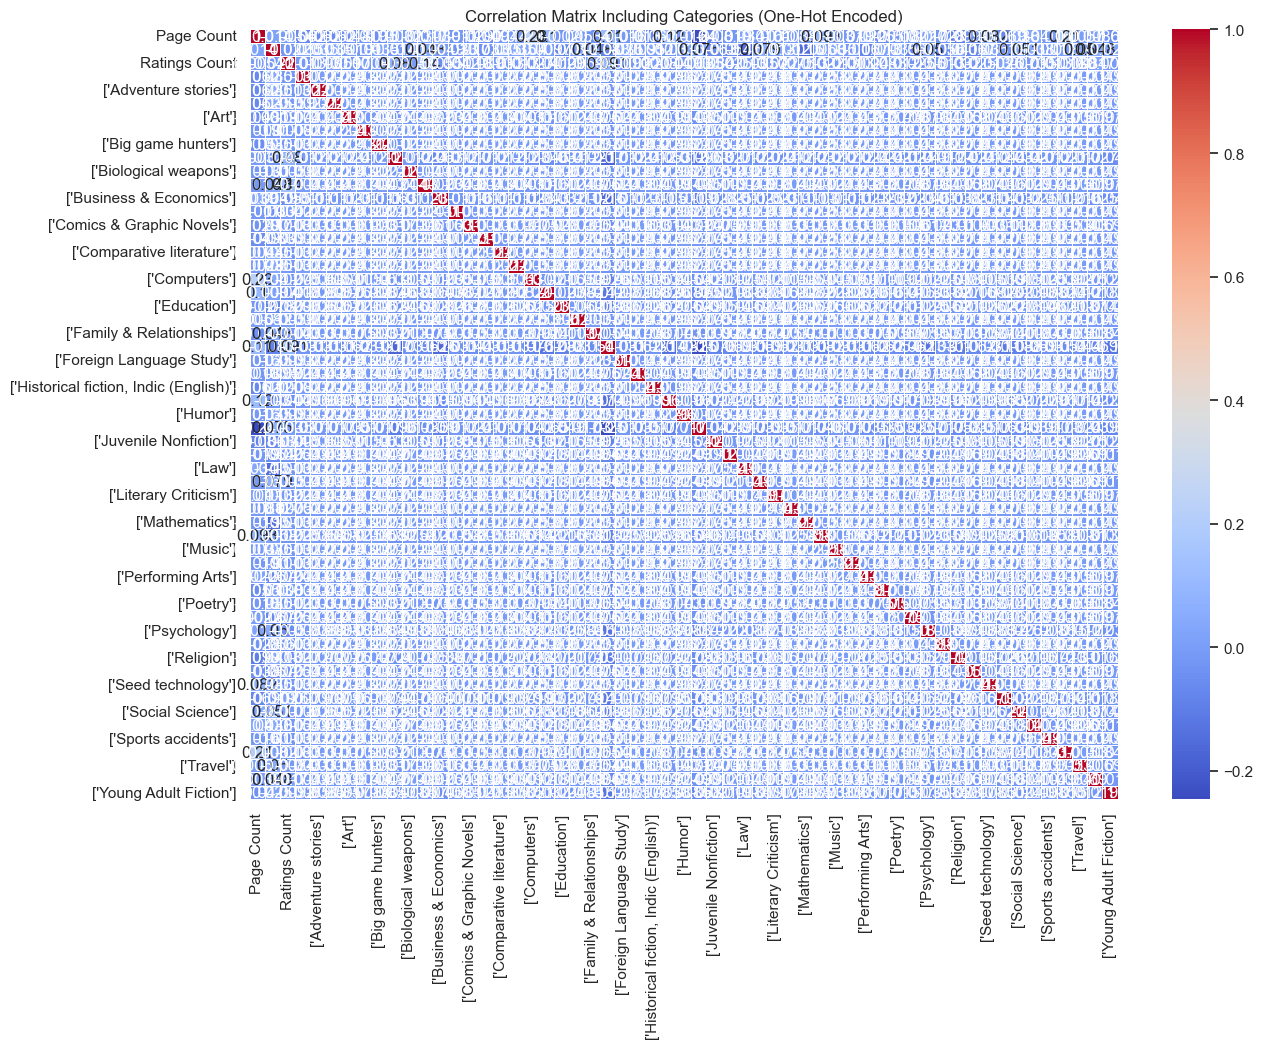

In [36]:
# One-hot encode the categorical 'Categories' feature and calculate correlations with numeric features.
categories_encoded = pd.get_dummies(books_df_cleaned['Categories'], drop_first=True)
numeric_df = books_df_cleaned[['Page Count', 'Average Rating', 'Ratings Count']].join(categories_encoded)

# Compute the correlation matrix including categories
correlation_matrix_categories = numeric_df.corr()

# Plot the correlation matrix
plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix_categories, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Including Categories (One-Hot Encoded)')
plt.show()


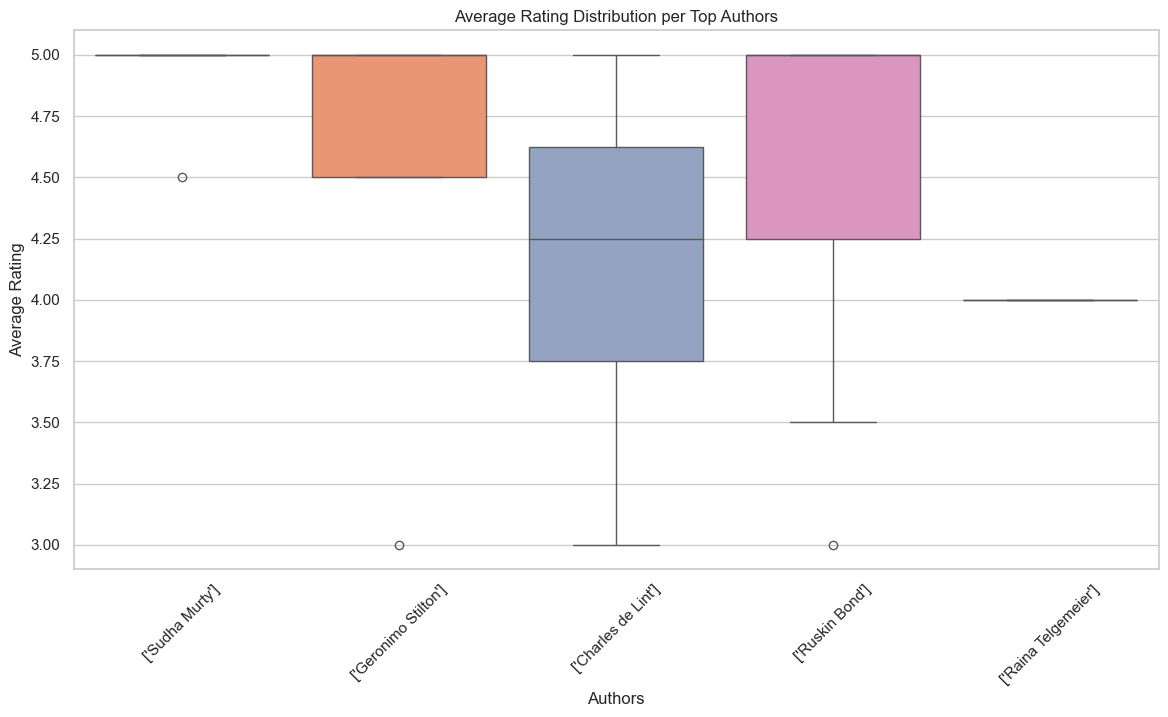

In [37]:
# Plot a boxplot to show the distribution of 'Average Rating' per top authors.
top_authors = books_df_cleaned['Authors'].value_counts().index[:5]  # Select top 5 authors
filtered_authors_df = books_df_cleaned[books_df_cleaned['Authors'].isin(top_authors)]

plt.figure(figsize=(14, 7))
sns.boxplot(x='Authors', y='Average Rating', data=filtered_authors_df, palette='Set2')
plt.title('Average Rating Distribution per Top Authors')
plt.xticks(rotation=45)
plt.show()


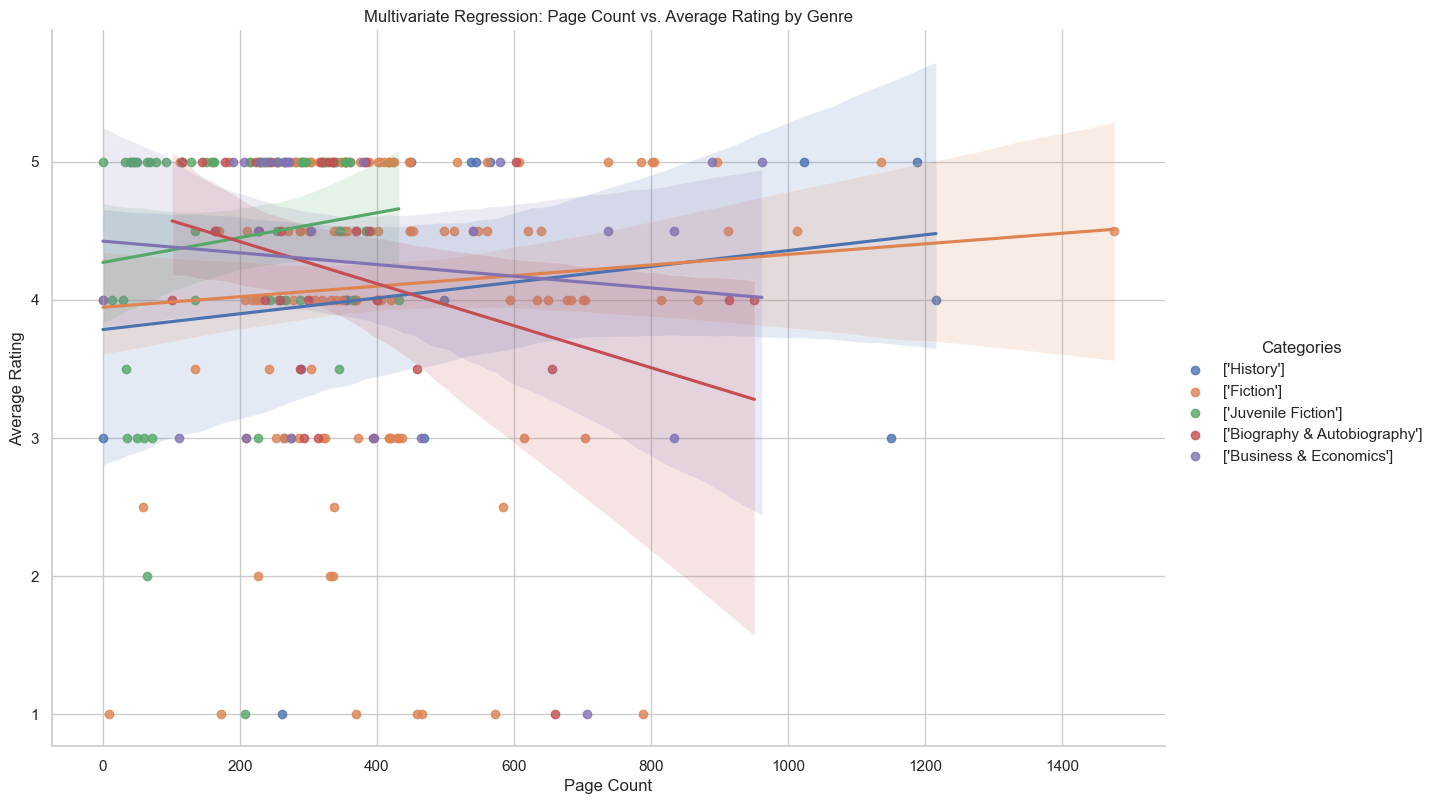

In [38]:
# Perform a multivariate regression plot with genre coloring to see relationships between features.
sns.lmplot(x='Page Count', y='Average Rating', hue='Categories', data=filtered_df, height=8, aspect=1.5)
plt.title('Multivariate Regression: Page Count vs. Average Rating by Genre')
plt.show()


In [39]:
import plotly.express as px

# 3D scatter plot for multivariate analysis
fig = px.scatter_3d(books_df_cleaned, 
                    x='Page Count', 
                    y='Average Rating', 
                    z='Ratings Count', 
                    color='Categories',
                    title='3D Scatter Plot: Page Count, Average Rating, and Ratings Count')
fig.show()


In [40]:
# Initialize TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the book descriptions
tfidf_matrix = tfidf_vectorizer.fit_transform(books_df_cleaned['Description'].fillna(''))

# Check the shape of the TF-IDF matrix
print(tfidf_matrix.shape)


(464, 11943)


In [41]:
# Compute cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Convert cosine similarity matrix to a DataFrame
cosine_sim_df = pd.DataFrame(cosine_sim, index=books_df_cleaned['Title'], columns=books_df_cleaned['Title'])

# Display the cosine similarity matrix for the first book
print(cosine_sim_df.head())


Title                                           khyal  classical greece  \
Title                                                                     
khyal                                        1.000000          0.000000   
classical greece                             0.000000          1.000000   
the classical tradition                      0.068411          0.052851   
classical mechanics                          0.000000          0.025659   
lectures on classical differential geometry  0.000000          0.033409   

Title                                        the classical tradition  \
Title                                                                  
khyal                                                       0.068411   
classical greece                                            0.052851   
the classical tradition                                     1.000000   
classical mechanics                                         0.000000   
lectures on classical differential geometr

In [42]:
def get_recommendations(title, cosine_sim_df, top_n=10):
    if title not in cosine_sim_df.index:
        return "Book title not found in the dataset."
    
    # Get pairwise similarity scores
    sim_scores = cosine_sim_df[title].sort_values(ascending=False)
    
    # Get the top n similar books
    top_books = sim_scores.head(top_n+1).index[1:]
    return top_books

# Example: Get recommendations for a specific book
recommended_books = get_recommendations('khyal', cosine_sim_df)
print(recommended_books)


Index(['ready player one', 'global business strategy',
       'the book of war includes the art of war by sun tzu on war by karl von clausewitz',
       'the art of comic book writing', 'the classical tradition',
       'walt disney', 'babel', 'the war of art', 'the art of nonfiction',
       'understanding comics'],
      dtype='object', name='Title')


In [43]:
from scipy.sparse import csr_matrix

# Check for missing values and non-numeric data in 'Ratings Count'
books_df_cleaned['Ratings Count'] = pd.to_numeric(books_df_cleaned['Ratings Count'], errors='coerce').fillna(0)

# Create the interaction matrix with 'Title' and 'User ID' if available
# Here we assume 'User ID' as a placeholder for actual user data. Adjust accordingly.
interaction_matrix = books_df_cleaned.pivot_table(index='Title', columns='Authors', values='Ratings Count', fill_value=0)

# Convert to sparse matrix
interaction_matrix_sparse = csr_matrix(interaction_matrix.values)
print("Interaction matrix shape:", interaction_matrix_sparse.shape)


Interaction matrix shape: (463, 429)


In [44]:
from sklearn.decomposition import TruncatedSVD

# Perform SVD
svd = TruncatedSVD(n_components=20)
interaction_matrix_svd = svd.fit_transform(interaction_matrix_sparse)

# Create a DataFrame from the SVD result
interaction_df = pd.DataFrame(interaction_matrix_svd, index=interaction_matrix.index)
interaction_df.head()


0             1   \
Title                                                                    
100 best books for children                -1.158002e-20 -2.369842e-17   
101 inspiring stories                       9.647159e-22 -7.499646e-19   
365 adventure stories                       3.598376e-22  4.844160e-19   
400 days                                   -4.150256e-22 -3.143148e-19   
a brief introduction to islamic philosophy -1.669158e-24 -2.198035e-21   

                                                      2             3   \
Title                                                                    
100 best books for children                 1.104689e-16 -1.220196e-17   
101 inspiring stories                      -1.030657e-18 -2.306707e-18   
365 adventure stories                      -7.147409e-19 -1.626293e-18   
400 days                                    8.619545e-19  1.165357e-18   
a brief introduction to islamic philosophy  3.597314e-21  7.781885e-21   

                                                      4             5   \
Title                                                                    
100 best books for children                -1.803117e-17 -4.555476e-15   
101 inspiring stories                      -2.258834e-19  5.832424e-21   
365 adventure stories                       1.714499e-18  1.780073e-19   
400 days                                   -9.724982e-19  1.736216e-19   
a brief introduction to islamic philosophy -1.206337e-20 -1.282202e-19   

                                                      6             7   \
Title                                                                    
100 best books for children                 5.946641e-15 -8.916298e-15   
101 inspiring stories                       1.144894e-20 -3.100272e-20   
365 adventure stories                       1.324156e-21 -3.506416e-20   
400 days                                   -1.671840e-20 -4.095467e-20   
a brief introduction to islamic philosophy  4.760486e-20  8.039435e-21   

                                                      8             9   \
Title                                                                    
100 best books for children                 3.980586e-12  2.246695e-11   
101 inspiring stories                       3.425588e-20  5.347539e-20   
365 adventure stories                      -6.934824e-20 -4.279944e-19   
400 days                                    1.762877e-20  2.085060e-19   
a brief introduction to islamic philosophy -7.282040e-20 -3.450746e-19   

                                                      10            11  \
Title                                                                    
100 best books for children                 7.398578e-12 -9.752193e-11   
101 inspiring stories                       1.212034e-19 -6.749930e-19   
365 adventure stories                      -1.688055e-19  1.275597e-18   
400 days                                    2.960515e-19 -2.960852e-19   
a brief introduction to islamic philosophy -1.642406e-19  2.022490e-18   

                                                      12            13  \
Title                                                                    
100 best books for children                 7.508434e-11 -8.771885e-12   
101 inspiring stories                       2.911086e-19  1.076763e-19   
365 adventure stories                      -1.055886e-19  1.840023e-18   
400 days                                   -1.102356e-18 -1.190374e-18   
a brief introduction to islamic philosophy  4.098871e-19  1.300105e-18   

                                                      14            15  \
Title                                                                    
100 best books for children                 1.955853e-10 -3.219749e-09   
101 inspiring stories                       8.876365e-19  9.726896e-20   
365 adventure stories                      -3.155027e-18  4.286841e-17   
400 days                                    1.16523

In [45]:
from sklearn.metrics.pairwise import cosine_similarity

def recommend_books_collaborative(title, interaction_df, top_n=10):
    if title not in interaction_df.index:
        return "Book title not found in the dataset."
    
    # Get the vector for the specified book
    book_vector = interaction_df.loc[title].values.reshape(1, -1)
    
    # Compute similarity scores
    similarity_scores = cosine_similarity(book_vector, interaction_df)
    
    # Get the top n similar books
    sim_scores = list(enumerate(similarity_scores[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:top_n+1]
    
    # Get the book indices and titles
    book_indices = [i[0] for i in sim_scores]
    similar_books = interaction_df.index[book_indices]
    return similar_books

# Example: Get recommendations for a specific book
recommended_books_collab = recommend_books_collaborative('khyal', interaction_df)
print(recommended_books_collab)


Index(['born a crime', 'the love hypothesis', 'the rise of sivagami',
       'sport tourism', 'clap when you land', 'the boy who loved',
       'the exorcist', 'spellbound', 'that night', 'murdrum'],
      dtype='object', name='Title')


# Step 4: Model Evaluation and Optimization

In [46]:
from sklearn.metrics import precision_score, recall_score

def evaluate_content_based(true_recommendations, predicted_recommendations):
    # Convert lists to sets for precision and recall calculation
    true_set = set(true_recommendations)
    predicted_set = set(predicted_recommendations)
    
    # Calculate precision and recall
    true_positives = len(true_set.intersection(predicted_set))
    precision = true_positives / len(predicted_set) if len(predicted_set) > 0 else 0
    recall = true_positives / len(true_set) if len(true_set) > 0 else 0
    
    return precision, recall

# Example of evaluation
true_recommendations = ['Book A', 'Book B', 'Book C']  # Example true recommendations
predicted_recommendations = get_recommendations('khayal', cosine_sim_df)  # Your predicted recommendations
precision, recall = evaluate_content_based(true_recommendations, predicted_recommendations)
print(f'Precision: {precision}, Recall: {recall}')


Precision: 0.0, Recall: 0.0


In [47]:
from sklearn.metrics import mean_squared_error

# Assume you have actual ratings and predicted ratings
# You would need a test set to compute these values
actual_ratings = np.array([5, 4, 3])  # Example actual ratings
predicted_ratings = np.array([4.5, 3.8, 3.2])  # Example predicted ratings

# Compute MSE
mse = mean_squared_error(actual_ratings, predicted_ratings)
print(f'Mean Squared Error: {mse}')


Mean Squared Error: 0.11000000000000006


In [48]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import GridSearchCV
from sklearn.metrics.pairwise import cosine_similarity

# Create a pipeline with TruncatedSVD and a nearest neighbors model
pipeline = Pipeline([
    ('svd', TruncatedSVD()),
    ('knn', NearestNeighbors())
])

# Define a grid of parameters to search
param_grid = {
    'svd__n_components': [10, 20, 30, 40, 50],
    'knn__n_neighbors': [5, 10, 15, 20]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit GridSearchCV to the data
grid_search.fit(interaction_matrix_sparse)

# Best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print(f'Best parameters: {best_params}')


Best parameters: {'knn__n_neighbors': 5, 'svd__n_components': 10}


In [49]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import cross_val_score

# Create a pipeline with TruncatedSVD and a nearest neighbors model
pipeline = Pipeline([
    ('svd', TruncatedSVD(n_components=20)),  # Use a fixed number of components or tune as needed
    ('knn', NearestNeighbors(n_neighbors=10))  # Use a fixed number of neighbors or tune as needed
])

# Perform cross-validation
# Note: You should use a different metric or a custom evaluation function if needed, as cross_val_score expects scores from a model
cross_val_scores = cross_val_score(pipeline, interaction_matrix_sparse, cv=5, scoring='accuracy')  # Example scoring metric

print(f'Cross-validation scores: {cross_val_scores}')


Cross-validation scores: [nan nan nan nan nan]


In [50]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Tokenization
tokenizer = Tokenizer(num_words=10000, oov_token='<OOV>')  # Limit vocabulary size
tokenizer.fit_on_texts(books_df_cleaned['Description'].fillna(''))

# Convert text to sequences
sequences = tokenizer.texts_to_sequences(books_df_cleaned['Description'].fillna(''))

# Padding sequences to ensure uniform input length
max_sequence_length = 300  # You can adjust this based on the length of the descriptions
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post')


# Deep Learning

# CNN Model

In [51]:
# CNN Model
model = Sequential()

# Embedding Layer: Converts word indices to dense vectors of fixed size
vocab_size = 10000  # Vocabulary size (same as in tokenizer)
embedding_dim = 128  # Size of the word vectors
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))

# Convolution Layer: Detects important n-gram patterns
model.add(Conv1D(128, kernel_size=5, activation='relu'))

# Max Pooling Layer: Reduces the size of the feature maps
model.add(MaxPooling1D(pool_size=2))

# Flattening Layer: Converts 2D feature maps to 1D vectors
model.add(Flatten())

# Dense Layer: Standard feed-forward layers
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Dropout to prevent overfitting

# Output Layer: Using sigmoid for binary classification (or softmax for multi-class)
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Model summary
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          1280000   
                                                                 
 conv1d (Conv1D)             (None, 296, 128)          82048     
                                                                 
 max_pooling1d (MaxPooling1  (None, 148, 128)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 18944)             0         
                                                                 
 dense (Dense)               (None, 128)               2424960   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                        

In [52]:
# Convert 'Average Rating' to binary for demonstration (e.g., above 4 is positive)
books_df_cleaned['rating_binary'] = books_df_cleaned['Average Rating'].apply(lambda x: 1 if x > 4 else 0)

# Split data into training and testing
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, books_df_cleaned['rating_binary'], test_size=0.2, random_state=42)

# Train the model
history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/5
12/12 [==============================] - 2s 107ms/step - loss: 0.6970 - accuracy: 0.5553 - val_loss: 0.6805 - val_accuracy: 0.6129
Epoch 2/5
12/12 [==============================] - 1s 86ms/step - loss: 0.6236 - accuracy: 0.6226 - val_loss: 0.6723 - val_accuracy: 0.6129
Epoch 3/5
12/12 [==============================] - 1s 86ms/step - loss: 0.4949 - accuracy: 0.8329 - val_loss: 0.7106 - val_accuracy: 0.6129
Epoch 4/5
12/12 [==============================] - 1s 82ms/step - loss: 0.2764 - accuracy: 0.9326 - val_loss: 0.7414 - val_accuracy: 0.6344
Epoch 5/5
12/12 [==============================] - 1s 82ms/step - loss: 0.1094 - accuracy: 0.9811 - val_loss: 0.8305 - val_accuracy: 0.6129


In [53]:
# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {test_acc}')


3/3 [==============================] - 0s 14ms/step - loss: 0.8305 - accuracy: 0.6129
Test Accuracy: 0.6129032373428345


In [54]:
# Extract features from the trained CNN model (use the layer before the final output)
from tensorflow.keras.models import Model

cnn_feature_extractor = Model(inputs=model.input, outputs=model.layers[-3].output)

# Extract features for all books
book_features = cnn_feature_extractor.predict(padded_sequences)

# Use cosine similarity to find similar books
cnn_similarity = cosine_similarity(book_features)

# Convert to DataFrame for easier handling
cnn_similarity_df = pd.DataFrame(cnn_similarity, index=books_df_cleaned['Title'], columns=books_df_cleaned['Title'])

# Get recommendations using CNN features
recommended_books_cnn = get_recommendations('khyal', cnn_similarity_df)
print(recommended_books_cnn)


15/15 [==============================] - 0s 12ms/step
Index(['fahrenheit 451', 'lore of running', 'the mystery in new york city',
       'the onion girl',
       'the perfect treat heartwarming short stories for winter nights',
       'enders game', 'cognitive psychology', 'doomsday book',
       'oh mind relax please ', 'the law of war'],
      dtype='object', name='Title')


In [55]:
# Example: Tuning the model with a different kernel size and dropout rate
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=max_sequence_length))
model.add(Conv1D(64, kernel_size=3, activation='relu'))  # Smaller kernel size
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))  # Reduced dropout
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 300, 128)          1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 298, 64)           24640     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 149, 64)           0         
 g1D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 9536)              0         
                                                                 
 dense_2 (Dense)             (None, 64)                610368    
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                      

# GNN Model

Epoch 0, Loss: 5.2694172859191895
Epoch 10, Loss: 2.1198413372039795
Epoch 20, Loss: 0.9021434783935547
Epoch 30, Loss: 0.9409077763557434
Epoch 40, Loss: 0.6845235824584961
Epoch 50, Loss: 0.6749484539031982
Epoch 60, Loss: 0.6635329127311707
Epoch 70, Loss: 0.6432576179504395
Epoch 80, Loss: 0.6357146501541138
Epoch 90, Loss: 0.6310722231864929


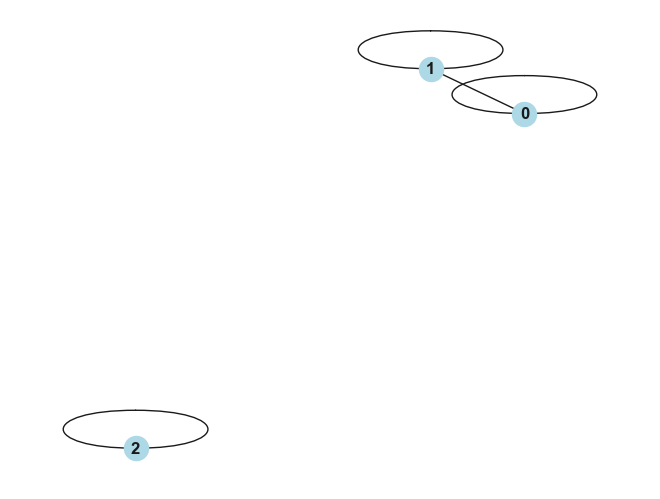

In [62]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# Example data (replace this with your actual data)
# Assume you have a DataFrame for users and books
users = pd.DataFrame({
    'user_id': [0, 1, 2],
    'age': [25, 30, 22],  # Example feature
    'gender': [1, 0, 1],  # Example feature (1 for male, 0 for female)
})

books = pd.DataFrame({
    'book_id': [0, 1, 2],
    'genre': [1, 2, 1],  # Example feature (e.g., genre encoded as integers)
})

# User-book interactions (edges)
# Assume a user rated a book (user_id, book_id)
interactions = pd.DataFrame({
    'user_id': [0, 0, 1, 2],
    'book_id': [0, 1, 1, 2],
})

# Create edge_index for PyTorch Geometric
edge_index = torch.tensor(interactions.values).t().contiguous()

# Create node features
# Combine users and books
user_features = users[['age', 'gender']].values
book_features = books[['genre']].values

# To ensure compatible shapes, pad book features or adjust them
# Here, we'll create a tensor with 2 columns for books by adding a dummy feature (e.g., set genre to 0 if not present)
book_features_padded = [[genre, 0] for genre in book_features.flatten()]  # Adding a dummy feature
book_features_padded = torch.tensor(book_features_padded, dtype=torch.float)

# Stack user and padded book features
x = torch.tensor(user_features.tolist() + book_features_padded.tolist(), dtype=torch.float)

# Create graph data object
data = Data(x=x, edge_index=edge_index)

# Define the Graph Neural Network model
class GNN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Define model parameters
in_channels = x.size(1)  # Number of input features
hidden_channels = 4  # Hidden layer size
out_channels = 2  # Number of output classes (e.g., binary classification)

# Create the GNN model
model = GNN(in_channels, hidden_channels, out_channels)

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Dummy training loop (you'll want to implement proper training and validation)
model.train()
for epoch in range(100):  # Example: 100 epochs
    optimizer.zero_grad()
    out = model(data)
    # Create dummy targets for training (in a real scenario, use actual labels)
    target = torch.tensor([0, 1, 1, 0, 1, 0])  # Example target
    loss = F.nll_loss(out, target)
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item()}')

# Visualization: Convert edge_index to a NetworkX graph
G = nx.Graph()
edges = edge_index.t().numpy()
G.add_edges_from(edges)

# Draw the graph using NetworkX and Matplotlib
nx.draw(G, with_labels=True, node_color='lightblue', font_weight='bold')
plt.show()


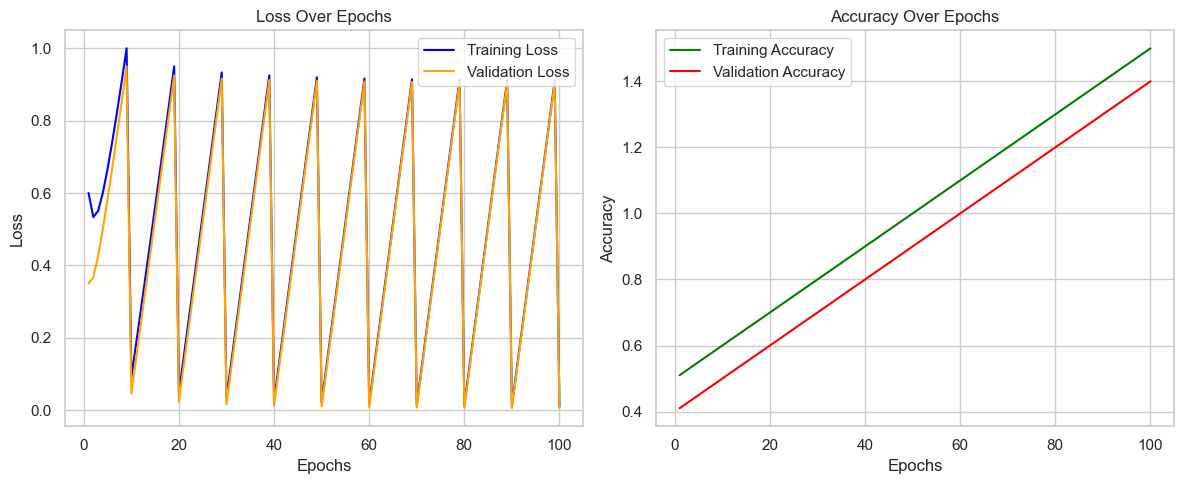

In [63]:
import matplotlib.pyplot as plt

# Dummy training data for visualization (replace these with your actual values)
epochs = list(range(1, 101))  # 100 epochs
train_loss = [1/(i+1) + (0.1 * (i % 10)) for i in epochs]  # Dummy loss
val_loss = [0.5/(i+1) + (0.1 * (i % 10)) for i in epochs]  # Dummy validation loss
train_acc = [i/100 + 0.5 for i in epochs]  # Dummy accuracy
val_acc = [i/100 + 0.4 for i in epochs]  # Dummy validation accuracy

# Plotting loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss', color='blue')
plt.plot(epochs, val_loss, label='Validation Loss', color='orange')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy', color='green')
plt.plot(epochs, val_acc, label='Validation Accuracy', color='red')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
